# SEQP Personalized Signal Generator
This is a Jupyter notebook designed to create a personalized version of the SEQP test signal. 

1) Type in your callsign and grid square below.
2) Click "Run All Cells."

In [1]:
call = 'KD8OXT'
maidenhead = 'EN91em'

### 0) Housekeeping: Import packages and set audio parameters

In [2]:
fs = 48000;                   # samples per second
dt = 1/fs;                    # seconds per sample
wpm = 20

In [3]:
import morse_talk as mtalk
import pandas as pd
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt

## 1) Generate pseudorandom signal from user's callsign and grid square.
Notion for a pseudorandom code: generate two seconds of static - one from the callsign, one from the grid square. We'll stick them together. -- Going to leave this out for the moment because python's random number seeds aren't very predictable.

Aidan -- I'm not sure that this is the correct way to replicate the distribution of matlab's wgn function. Maybe we ask Rachel tomorrow?

In [4]:
def pseudorandom_from_string(s):
    rng = default_rng(list(s.encode('utf-8')))
    return rng.normal(scale=np.sqrt(1/20), size=fs)

The results of this function should be repeatable no matter how many times you run this function, or restart the notebook kernel.

In [5]:
pseudorandom_from_string(call)

array([-0.26048525, -0.04555744, -0.23402763, ..., -0.30995779,
       -0.22072455,  0.42672275])

In [6]:
pseudorandom_from_string(call)

array([-0.26048525, -0.04555744, -0.23402763, ..., -0.30995779,
       -0.22072455,  0.42672275])

In [7]:
call_static = pseudorandom_from_string(call)
grid_static = pseudorandom_from_string(maidenhead)
static = np.concatenate((call_static, grid_static))

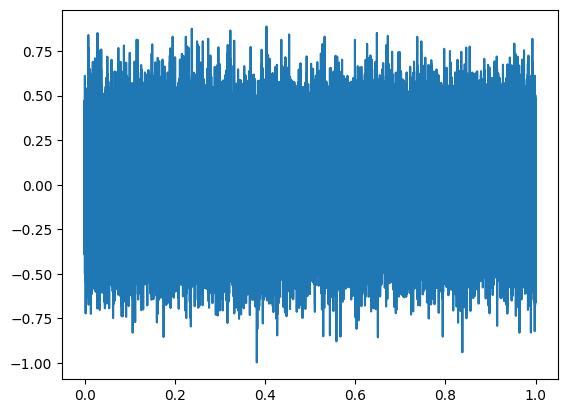

In [8]:
plt.plot(np.linspace(0,1,2 * fs), static)
plt.show()

All the work below here in this section is to compare this test noise to the wwv characterization noise.

In [9]:
wwv_characterization = pd.read_csv('test.csv',header=None).squeeze('columns').to_numpy()

In [10]:
len(wwv_characterization)

2016000

In [11]:
len(wwv_characterization)/fs

42.0

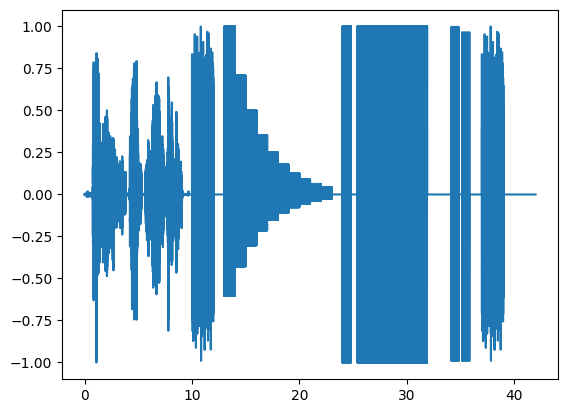

In [12]:
plt.plot(np.linspace(0,42, 42*fs), wwv_characterization)

In [13]:
wwv_noise = wwv_characterization[10 * fs:(10+2) * fs]

In [14]:
len(wwv_noise)

96000

In [15]:
len(wwv_noise)/fs

2.0

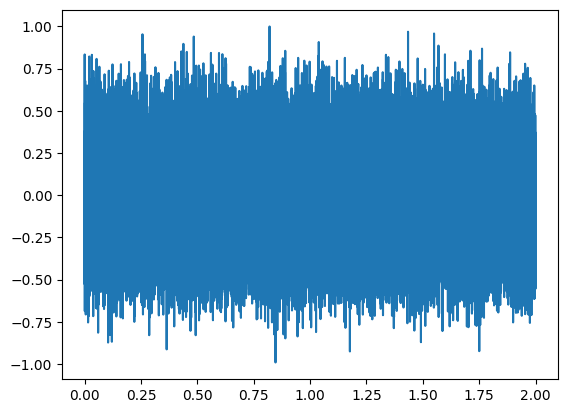

In [16]:
plt.plot(np.linspace(0,2,2*fs), wwv_noise)

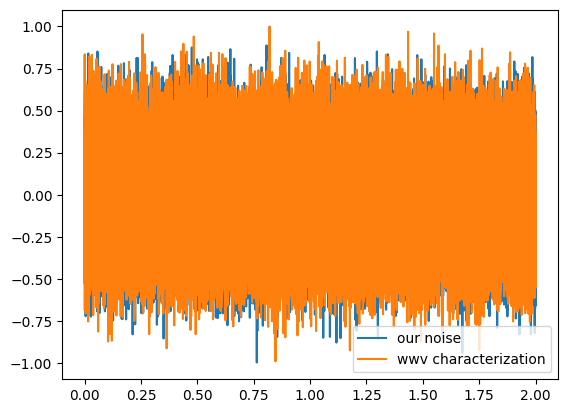

In [17]:
plt.plot(np.linspace(0,2,2*fs), static, label="our noise")
plt.plot(np.linspace(0,2,2*fs), wwv_noise, label="wwv characterization")
plt.legend()
plt.show()

## 2) Generate Morse signal from user's callsign. 
This signal is at 20 WPM. All callsigns must fit in the same time block... and should be received by RBN.

In [18]:
msg = 'TEST TEST TEST de ' + call + " " + call + " " + call + "  " + maidenhead+ "  " + maidenhead
# msg = msg * 3
print(msg)

TEST TEST TEST de KD8OXT KD8OXT KD8OXT  EN91em  EN91em


Let's convert the signal to an on-off signal:

In [19]:
msg_cw = mtalk.encode(msg, encoding_type='binary')
msg_cw = np.array(list(msg_cw))
#msg_cw = pd.DataFrame(msg_cw)

In [26]:
len(msg_cw)

477

We have to make sure this fits into a standard time frame, so let's prallocate an array of desired length, convert it to a list, and then add it in:

In [52]:
def length_of_dit(wpm):
    """length of a dit in seconds given a words per minute"""
    return 1200/wpm/1000 # seconds

In [45]:
assert length_of_dit(12) == 0.1

In [46]:
length_of_dit(wpm)

60.0

In [48]:
# length of cw message, seconds
len(msg_cw) * length_of_dit(wpm)

28.619999999999997

In [49]:
# length of cw message, samples
_ * fs

1373759.9999999998

In [ ]:
# ...

## 3) Concatenate CW and radar chirps

Now we add in the lightsaber noises. Er, chirps. 

Chirps from [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7659302.svg)](https://doi.org/10.5281/zenodo.7659302).

In [20]:
data = pd.read_csv('https://zenodo.org/record/7659302/files/seqp-test.csv?download=1').squeeze('columns')
chirps = data.to_numpy()#.transpose()
chirps

array([0.        , 0.        , 0.        , ..., 0.70699947, 0.70699989,
       0.70699999])

In [21]:
print(static.shape)
print(msg_cw.shape)
print(chirps.shape)

(96000,)
(477,)
(515999,)


In [22]:
signal = np.concatenate((static, msg_cw, chirps))
signal

array(['-0.26048524968170766', '-0.04555743649662939',
       '-0.23402762959113113', ..., '0.706999467635388',
       '0.706999894841548', '0.706999993427597'], dtype='<U32')

In [24]:
len(signal)

612476

In [25]:
len(signal) / fs

12.759916666666667

## 4) Save File
Let's save the resulting .CSV and .WAV files with mnemonic filenames that include callsign and grid square.

In [23]:
filename = 'SEQP Test Signal ' + call + ' ' + maidenhead
series = pd.Series(signal)
series.to_csv(filename+'.csv')